# Classical Random Circuits

Here we use classical circuits to get a handle on error rates.

## setup

In [1]:
import os
import random
from typing import List
import itertools
import networkx as nx
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from pyquil.api import get_qc, QuantumComputer
from pyquil.gates import CNOT, CCNOT, X, I, H, CZ, MEASURE, RESET
from pyquil.quilbase import Pragma
from scipy.spatial.distance import hamming

from forest_benchmarking.compilation import basic_compile

from forest_benchmarking.classical_random_circuits import *

## graph state measurement and plotting functions

In [2]:
#qc_perfect = get_qc("Aspen-1-15Q-A", as_qvm=True, noisy=False)
#qc_noisy = get_qc("Aspen-1-15Q-A", as_qvm=True, noisy=True)

qc_perfect = get_qc("9q-square-qvm", as_qvm=True, noisy=False)
qc_noisy = get_qc("9q-square-qvm", as_qvm=True, noisy=True)

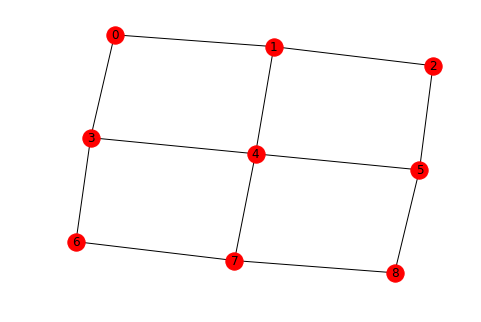

In [3]:
nx.draw(qc_perfect.qubit_topology(),with_labels=True)

In [4]:
#from pyquil import *
#list_quantum_computers()

In [5]:
G = qc_perfect.qubit_topology()
len(qc_perfect.qubit_topology())
# distribution of graph lengths
disty = []
for gdx in range(1,len(G.nodes)+1):
    listg = generate_connected_subgraphs(G,gdx)
    disty.append(len(listg))

disty

[9, 12, 22, 36, 49, 48, 32, 9, 1]

In [6]:
G = qc_perfect.qubit_topology()

In [7]:
num_shots_per_circuit = 1
num_rand_subgraphs = 2
num_rand_circuits_per_subgraph = 2
depth = 5
widthy = 3 #max = len(G.nodes)
in_x_basis = False

In [8]:
data = []
# loop over different graph sizes
for depth_idx,subgraph_size in itertools.product(range(1,depth+1), range(1,widthy+1)):
    list_of_graphs = generate_connected_subgraphs(G, subgraph_size)
    wt = []
    for kdx in range(1, num_rand_subgraphs+1):
        # randomly choose a lattice from list
        lattice = random.choice(list_of_graphs)
        for jdx in range(1, num_rand_circuits_per_subgraph+1):
            prog = generate_random_classial_circuit_with_depth(lattice, depth_idx, in_x_basis)
            # perfect 
            perfect_bitstring = qc_perfect.run_and_measure(prog, trials=1)
            perfect_bitstring_array = np.vstack(perfect_bitstring[q] for q in prog.get_qubits()).T
            # run on hardware or noisy QVM
            actual_bitstring = qc_noisy.run_and_measure(prog, trials=3)
            actual_bitstring_array = np.vstack(actual_bitstring[q] for q in prog.get_qubits()).T
            wt.append(get_error_hamming_distance_from_results(perfect_bitstring_array, actual_bitstring_array))

    # for each graph size flatten the results        
    wt_flat = [item for sublist in wt for item in sublist]
    hamming_wt_distr = get_error_hamming_distributions_from_list(wt_flat, subgraph_size)
    # list of dicts. The keys are (depth, width, hamming_dist)
    data.append({'depth': depth_idx, 'width': subgraph_size, 'hamming_dist': hamming_wt_distr})

In [9]:
df = pd.DataFrame(data)
df

,depth,hamming_dist,width
0,1,"[0.8333333333333334, 0.0]",1
1,1,"[0.9166666666666666, 0.08333333333333333, 0.0]",2
2,1,"[0.8333333333333334, 0.16666666666666666, 0.0,...",3
3,2,"[0.8333333333333334, 0.0]",1
4,2,"[0.8333333333333334, 0.16666666666666666, 0.0]",2
5,2,"[0.5833333333333334, 0.4166666666666667, 0.0, ...",3
6,3,"[1.0, 0.0]",1
7,3,"[0.9166666666666666, 0.08333333333333333, 0.0]",2
8,3,"[0.8333333333333334, 0.16666666666666666, 0.0,...",3
9,4,"[0.8333333333333334, 0.0]",1


In [10]:
def get_hamming_dist(df: pd.DataFrame, depth_val: int, width_val: int):
    idx = df.depth== depth_val
    jdx = df.width== width_val
    return df[idx&jdx].reset_index(drop=True)

def get_hamming_dists_fn_width(df: pd.DataFrame, depth_val: int):
    idx = df.depth== depth_val
    return df[idx].reset_index(drop=True)

def get_hamming_dists_fn_depth(df: pd.DataFrame, width_val: int):
    jdx = df.width== width_val
    return df[jdx].reset_index(drop=True)

# Plot a particular depth and width

In [11]:
dep = 2
wid = 2
distz = get_hamming_dist(df, dep, wid)

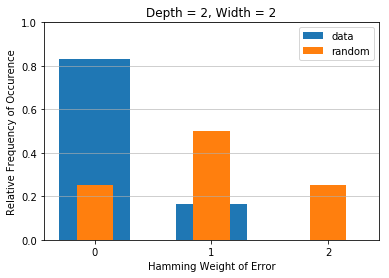

In [12]:

averaged_distr = distz['hamming_dist'][0]

rand_ans_distr = hamming_dist_rand(wid,0)

x_labels = np.arange(0, len(averaged_distr))
plt.bar(x_labels, averaged_distr, width=0.61, align='center')
plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
plt.xticks(x_labels)
plt.xlabel('Hamming Weight of Error')
plt.ylabel('Relative Frequency of Occurence')
plt.ylim([0,1])
plt.grid(axis='y', alpha=0.75)
plt.legend(['data','random'])
plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.show()

# For a particular width plot all depths

In [13]:
wid = 2
hdis = get_hamming_dists_fn_depth(df, wid)

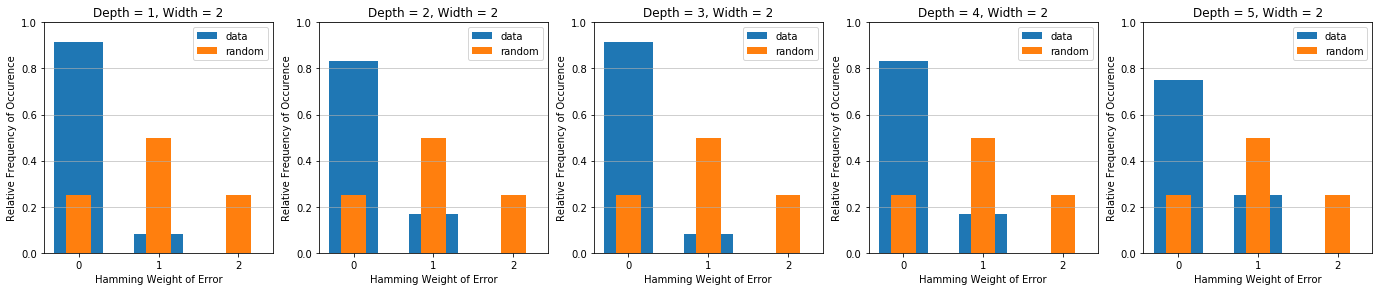

In [14]:
for hdx in range(0, len(hdis)):
    averaged_distr = hdis.iloc[hdx]['hamming_dist']
    dep = hdis.iloc[hdx]['depth']
    rand_ans_distr = hamming_dist_rand(wid,0)
    x_labels = np.arange(0, len(averaged_distr))
    plt.subplot(1,len(hdis),hdx+1)
    plt.bar(x_labels, averaged_distr, width=0.61, align='center')
    plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()

# Plot depth = width

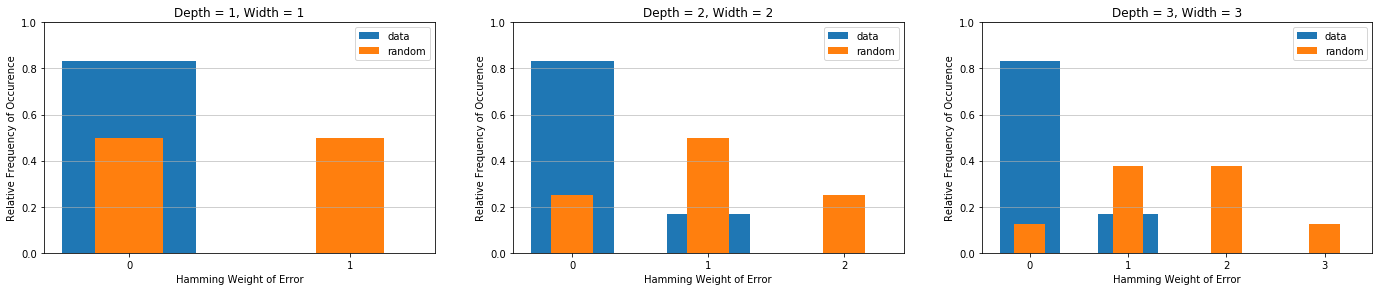

In [15]:
max_idx = min([max(df['depth']),max(df['width'])])

for idx in range(1,max_idx+1):
    hdis = get_hamming_dist(df, idx, idx)
    averaged_distr = hdis['hamming_dist'][0]
    dep = hdis['depth'][0]
    wid = hdis['width'][0]
    rand_ans_distr = hamming_dist_rand(idx,0)
    x_labels = np.arange(0, len(averaged_distr))
    plt.subplot(1,max_idx,idx)
    plt.bar(x_labels, averaged_distr, width=0.61, align='center')
    plt.bar(x_labels, rand_ans_distr, width=0.31, align='center')
    plt.xticks(x_labels)
    plt.xlabel('Hamming Weight of Error')
    plt.ylabel('Relative Frequency of Occurence')
    plt.ylim([0,1])
    plt.grid(axis='y', alpha=0.75)
    plt.legend(['data','random'])
    plt.title('Depth = {}, Width = {}'.format(dep,wid))
plt.subplots_adjust(bottom=0.1, right=3.2, top=0.9)
plt.show()
    
    
    

# Plot success probablity landscape

In [16]:
def interpolate_2d_landscape(points, values, resolution=200, interp_method='nearest'):
    """
    Convenience function for interpolating a list of points and corresponding list of values
    onto a 2D meshgrid suitable for plotting.

    See :py:func:`plot_2d_landscape`.

    :param points: A numpy array where the first column is x values and the second column
        is y values
    :param values: The value at each point (z)
    :param resolution: The number of points per side in the interpolated meshgrid
    :param interp_method: The scheme used for interpolation. "cubic" or "linear" will give
        you a prettier picture but "nearest" will prevent you from overconfidence.
    :return: meshgrid arrays (xx, yy, zz) suitable for plotting.
    """
    xx, yy = np.meshgrid(
        np.linspace(np.min(points[:, 0]), np.max(points[:, 0]), resolution),
        np.linspace(np.min(points[:, 1]), np.max(points[:, 1]), resolution),
    )
    zz = scipy.interpolate.griddata(points, values, (xx, yy), method=interp_method)
    return xx, yy, zz

In [17]:
points = np.vstack((df['depth'].values, df['width'].values)).T
points.shape

(15, 2)

In [25]:
import scipy.interpolate
# df['hamming_dist'][0] returns the array
# df['hamming_dist'][0][0] returns the first element of the array
values = np.asarray([df['hamming_dist'][idx][0] for idx in df.index])
values

array([0.83333333, 0.91666667, 0.83333333, 0.83333333, 0.83333333,
       0.58333333, 1.        , 0.91666667, 0.83333333, 0.83333333,
       0.83333333, 1.        , 1.        , 0.75      , 0.75      ])

In [31]:
rand_width = [hamming_dist_rand(idx, 0)[0] for idx in range(1,widthy+1)]
rand_width


values_rand = np.asarray([item for sublist in [rand_width for ddx in range(1,depth+1)] for item in sublist])

#values_rand = np.vstack((rand_width, rand_width, rand_width)).T
values_rand.shape

(15,)

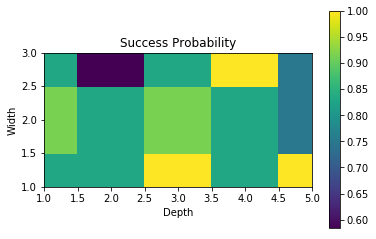

In [32]:
xx, yy, zz = interpolate_2d_landscape(points, values)

ax = plt.gca()
img = ax.imshow(zz, interpolation='none',
                extent=(xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]),
                cmap='viridis', origin='lowerleft', norm=plt.Normalize(None, None))
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability')
plt.show()

(15, 2)


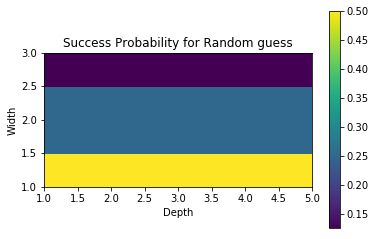

In [33]:
print(points.shape)
xx, yy, zz = interpolate_2d_landscape(points, values_rand)

ax = plt.gca()
img = ax.imshow(zz, interpolation='none',
                extent=(xx[0, 0], xx[0, -1], yy[0, 0], yy[-1, 0]),
                cmap='viridis', origin='lowerleft', norm=plt.Normalize(None, None))
plt.colorbar(img, ax=ax)
plt.xlabel('Depth')
plt.ylabel('Width')
plt.title('Success Probability for Random guess')
plt.show()

# Error probablity decay

In [ ]:
# one bit errors
#values = [df['hamming_dist'][idx][0]+df['hamming_dist'][idx][1] for idx in df.index]